In [1]:
# Add lib input sys.path
import os
import sys
import time

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.preprocessing import normalize
from functools import partial
import h5py
from scipy.spatial import distance
from sklearn import decomposition

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from matplotlib.colors import ListedColormap
import libs.linear_models as lm
import libs.data_util as data
import libs.nn as nn
import libs.plot as myplot

%matplotlib inline

#### Exercise 9.1

$x_g = (47,35)$, $x_b = (22, 40)$, $x_u = (21, 36)$

The distance from $x_u$ to Mr. Bad is closer than the distance to Mr. Good. So the BoL should NOT give hime credit.

If the income is measured in dollars, Mr. Unknown is closer to Mr. Good, so the BoL should give him credit.

In [5]:
# The distance between $x_u$ and the two points
print('--- Income measured in K')
xg = np.array([47, 35])
xb = np.array([22, 40])
xu = np.array([21, 36])

d_ug = np.linalg.norm(xu-xg)
d_ub = np.linalg.norm(xu-xb)
print(f"--- Distance from unknow to Mr. Good: {d_ug}")
print(f"--- Distance from unknow to Mr. Bad: {d_ub}")

print('--- Income measured in dollars')
# Income measured in dollars
xg = np.array([47, 35000])
xb = np.array([22, 40000])
xu = np.array([21, 36000])

d_ug = np.linalg.norm(xu-xg)
d_ub = np.linalg.norm(xu-xb)
print(f"--- Distance from unknow to Mr. Good: {d_ug}")
print(f"--- Distance from unknow to Mr. Bad: {d_ub}")

--- Income measured in K
--- Distance from unknow to Mr. Good: 26.019223662515376
--- Distance from unknow to Mr. Bad: 4.123105625617661
--- Income measured in dollars
--- Distance from unknow to Mr. Good: 1000.3379428972991
--- Distance from unknow to Mr. Bad: 4000.000124999998


#### Exercise 9.2

\begin{align*}
Z &= \gamma X \\
&= (I - \frac{1}{N}1 1^T)X \\
&= X - \frac{1}{N} 1 1^T X\\
&= X - 1\frac{1}{N} \begin{bmatrix}\sum^N_{i=1} x_{i1} & \sum^N_{i=1} x_{i2} & \dots & \sum^N_{i=1} x_{id}\end{bmatrix}  \\
&= X - 1\begin{bmatrix}\bar{x}_1 & \bar{x}_2 & \dots & \bar{x}_d\end{bmatrix}\\
&=  X - 1\bar{x}^T \\
\end{align*}

#### Exercise 9.3

\begin{align*}
Z &= \begin{bmatrix}z^T_1 \\ \dots \\ z^T_N \end{bmatrix}\\
&= \begin{bmatrix}(Dx_1)^T \\ \dots \\ (Dx_N)^T\end{bmatrix}\\
&= \begin{bmatrix}x_1^TD^T \\ \dots \\ x_N^TD^T \end{bmatrix}\\
&= \begin{bmatrix}x_1^TD \\ \dots \\ x_N^TD \end{bmatrix}\\
&= XD \\
\end{align*}

\begin{align*}
Z^TZ &= (XD)^TXD \\
&= D^TX^TXD\\
&= DX^TXD\\
\end{align*}

#### Exercise 9.4

* (a) $\text{variance}(x_1) = \text{variance}(\hat{x}_1) = 1$, $\text{variance}(x_2) = \text{variance}(\sqrt{1-\epsilon^2}\hat{x}_1+\epsilon\hat{x}_2) = (1-\epsilon^2)\text{variance}(\hat{x}_1)+ \epsilon^2 \text{variance}(\hat{x}_2) = 1$

$\text{covariance}(x_1,x_2) = E[(x_1 - \bar{x}_1)(x_2 - \bar{x}_2)] = E[x_1x_2] = E[\sqrt{1-\epsilon^2}\hat{x}^2_1 + \epsilon\hat{x}_1\hat{x}_2] = \sqrt{1-\epsilon^2}$

* (b) 

\begin{align*}
f(x) &= w_1x_1 + w_2x_2 \\
&= w_1\hat{x}_1 + w_2 (\sqrt{1-\epsilon^2}\hat{x}_1 + \epsilon \hat{x}_2) \\
&= (w_1 + w_2 \sqrt{1-\epsilon^2})\hat{x}_1 + w_2\epsilon \hat{x}_2 \\
&= \hat{w}_1\hat{x}_1 + \hat{w}_2 \hat{x}_2 \\
\end{align*}

So if we set $\hat{w}_1 = w_1 + w_2 \sqrt{1-\epsilon^2}, \hat{w}_2 = w_2\epsilon$, we see $f$ is linear in $x_1,x_2$.

* (c) From problem (b), we have $\hat{w}_1 = \hat{w}_2 = 1$, so we have $w_1 = \frac{\epsilon - \sqrt{1-\epsilon^2}}{\epsilon}, w_2 = \frac{1}{\epsilon}$, so that $C \ge w^2_1 + w^2_2 = 2\frac{1-\epsilon\sqrt{1-\epsilon^2}}{\epsilon^2}$

* (d) As $\epsilon \to 0$, we have the minimum $C \to \infty $. It means that we have to use a huge $C$ to be able to implement the target function, which is impossible here.

* (e) If there is significant noise in the data, with correlated inputs, it'll be hard to regularize the learning, and overfitting is likely. So var term can be high while bias can be low.

#### Exercise 9.5

We compute the distances between $x_1,x_2 $ with $x_{test}$, we have

$d^2_1 = |x_1 - x_{test}|^2 = \sum^d(a_i + 1)^2$ and $d^2_2 = |x_2 - x_{test}|^2 = 4 + \sum^d(b_i + 1)^2$.

Suppose there are $k$ $+1$s in $a_i$ and $l$ $+1$s in $b_i$, then we have

$d^2_1 = \sum^d(a_i + 1)^2 = 4k$ and $d^2_2 = 4 + 4l = 4(l+1)$.

To correctly classify $x_{test}$ we want to have $d_1 < d_2$, which indicates that $k < l+1$, i.e. $k\le l$.

So we need compute the probabilities of the number of $+1$ in $a$ is less than or equal to the number of $+1$s in $b$.
Both $a$ and $b$ have $d$ elements, by symmetry the probability of $P(k > l) = P(l < k)$, i.e. the probability of $a$ having more $+1$ than $b$ is equal to the probability of $a$ having less $+1$ than $b$. So we have

$2P(k>l) + P(k=l) = 1$, thus $P(k\le l) = P(k < l) + P(k=l) = \frac{1}{2}(1 + P(k=l))$

We only have to solve the probability $P(k=l)$. 

For a given $k$, the probability of $P\left[(a \text{ has } k\; +1)\cap (b \text{ has } k\; + 1)\right] = \frac{d \choose k}{2^d}\frac{d \choose k}{2^d} = \frac{{d \choose k}^2}{2^{2d}}$

So we have 

\begin{align*}
P(k=l) &= \sum^d_{k=0}P\left[(a \text{ has } k\; +1)\cap (b \text{ has } k\; + 1)\right]\\
&= \sum^d_{k=0}\frac{{d \choose k}^2}{2^{2d}}\\
&= \frac{1}{2^{2d}}\sum^d_{k=0} {d \choose k}^2\\
&= \frac{1}{2^{2d}}{2d \choose d}\\
&= \frac{1}{2^{2d}}\frac{(2d)!}{d!d!}\\
&\text{apply stirling approximation } n! = \sqrt{2\pi n}\left(\frac{n}{e}\right)^n\\
&\approx \frac{1}{2^{2d}}\frac{\sqrt{2\pi 2d}\left(\frac{2d}{e}\right)^{2d}}{\sqrt{2\pi d}\left(\frac{d}{e}\right)^d \sqrt{2\pi d}\left(\frac{d}{e}\right)^d}\\
&= \frac{1}{\sqrt{\pi d}}\\
\end{align*}

So $P(k\le l) = \frac{1}{2}(1 + P(k=l)) = \frac{1}{2} + \frac{1}{2}\frac{1}{\sqrt{\pi d}} = \frac{1}{2} + O(\frac{1}{\sqrt{d}})$

This is the probability of classifying $x_{test}$ correctly with two data points. 

If there's a third data point $x_3$, then to correctly classify the $x_{test}$, we need have both $d_1 < d_2$ and $d_1 < d_3$, so the probability $P = P(k \le l)P(k \le l) = \frac{1}{4} + O(\frac{1}{\sqrt{d}})$

The probability of correctly classifying the $x_{test}$ drop about half.

#### Exercise 9.6

* (a) A large offset shouldn't affect the 'natural axes' from PCA. They only change the origin of the natural axes, but not the directions. We don't have to perform centering before PCA.

* (b) If one dimension is inflated, this will increase the variance along the dimension and make PCA choose 'natural axes' along the inflated dimension. We should perform input normalized before doing PCA.

* (c) If we do input whitening, the 'natural axes' for the inputs can be any orthogonal axes. Rotation to any angle won't reveal that one dimension is more important than another because they are all equalized.

We shouldn't perform input whitening before doing PCA, because that will equalize all axes for the inputs. PCA won't be able to find axes that has large variances against other axes.

#### Exercise 9.7

* (a) 

\begin{align*}
z &= \begin{bmatrix}x^Tv_1 \\ \dots \\ x^Tv_k \end{bmatrix}\\
&= \begin{bmatrix}v_1^Tx \\ \dots \\ v_k^Tx \end{bmatrix}\\
&= \begin{bmatrix}v_1^T \\ \dots \\ v_k^T \end{bmatrix}x \\
&= V^Tx\\
\end{align*}

The dimension of $V$ is $d \times k$, its columns are the basis $v_1, \dots, v_d$

* (b) 

\begin{align*}
Z &= \begin{bmatrix} z^T_1\\ \dots \\ z^T_N \end{bmatrix}\\
&= \begin{bmatrix} (V^Tx_1)^T\\ \dots \\ (V^Tx_N)^T \end{bmatrix}\\
&= \begin{bmatrix} x^T_1V \\ \dots \\ x^T_NV \end{bmatrix}\\
&= \begin{bmatrix} x^T_1 \\ \dots \\ x^T_N \end{bmatrix}V\\
&= XV\\
\end{align*}

* (c) We consider the $z=V^Tx$ where $z$ has $d$ components, so $V$ is $d\times d$. $V=\begin{bmatrix}v_1^T \\ \dots \\ v_d^T \end{bmatrix}$, since $v$s are othrogonal, we have $V^TV = I$, so $V^T = V^{-1}$

\begin{align*}
\sum^d_{i=1} z^2_i &= \|z\|^2 \\
&= z^Tz \\
&=  (V^Tx)^T(V^Tx) \\
&= x^TVV^Tx \\
&= x^TVV^{-1}x \\
&= x^Tx \\
&= \sum^d_{i=1} x^2_i \\
\end{align*}

If we choose $k\le d$ for $z$, we thus have $\|z\| \le \|x\| $

#### Exercise 9.8

$U^TX = U^TU\Gamma V^T = \Gamma V^T$, $XV = U\Gamma V^T V = U\Gamma$, so we have 

$X^TU = V\Gamma$, i.e. $X^Tu_i = \gamma_i v_i$ and $Xv_i = \gamma_i u_i$

#### Exercise 9.9

Let $A$ be a $m\times n$ matrix, and $A=\begin{bmatrix} a_1 & \dots & a_n \end{bmatrix}$, where $a_i$ are column vectors of dimension $m\times 1$

* (a) $\|A\|^2_F = \sum_m \|\text{row}_m(A)\|^2 = \sum_n \|\text{column}_n(A)\|^2$

$AA^T = \begin{bmatrix} a_1 & \dots & a_n \end{bmatrix}\begin{bmatrix} a^T_1 \\ \dots \\ a^T_n \end{bmatrix} = \sum^n_{i=1} a_i a^T_i$

So $\text{trace}(AA^T) = \text{trace}(\sum^n_{i=1} a_i a^T_i) =\sum^n_{i=1} \text{trace}(a_i a^T_i) = \sum^n_{i=1} \sum^m_{j=1}a^2_{ij} = \sum^n_{i=1} \|a_i\|^2 = \|A\|^2_F$


Also $A^TA = \begin{bmatrix}a^T_1a_1 & a^T_1a_2 & \dots & a^T_1a_n \\ a^T_2a_1 & a^T_2a_2 & \dots & a^T_2a_n \\ \dots & \dots & \dots & \dots \\ a^T_na_1 & a^T_na_2 & \dots & a^T_na_n \\ \end{bmatrix}$, and $\text{trace}(A^TA) = \sum^n_{i=1} a^T_i a_i = \sum^n_{i=1} \|a_i\|^2 = \|A\|^2_F$

* (b) Apply the result from problem (a) 

\begin{align*}
\|UAV^T\|^2_F &= \text{trace}((UAV^T)^T(UAV^T)) \\
&= \text{trace}(VA^TU^TUAV^T) \\
&= \text{trace}(VA^TAV^T) \\
&= \text{trace}((AV^T)^T(AV^T)) \\
&\text{apply } trace(XX^T) = trace(X^TX), X = AV^T \\
&= \text{trace}((AV^T)(AV^T)^T) \\
&= \text{trace}((AV^T)(VA^T)) \\
&= \text{trace}(AA^T) \\
&= \|A\|^2_F\\
\end{align*}

#### Exercise 9.10

If all the singular values of $X$ are distinct, then the eigenvalues of $\Sigma$ are all distinct and positive or zero. 

* (a) Let $X$ has a dimension of $N\times d$, and with SVD, let $X=U\Gamma V^T$ where $U$ has a dimension of $N\times d$ and $V$ has a dimension of $d\times d$, so we have $U^TU=I_d$ and $V^TV=VV^T=I_d$. Also let $V=\begin{bmatrix}v_1 & \dots & v_d\end{bmatrix}$, where $v_i$ are the $d\times 1 $ column vector and they are orthonormal (basis). $\Gamma$ is the diagonal matrix of the singular values of $X$, and by construction it's ordered, i.e. $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_d \ge 0 $. 

Consider any direction $v=\sum^d_{i=1}q_iv_i$, it should have $\|v\|^2 = \sum^d_{i=1}q^2_i = 1$.

\begin{align*}
\text{var}(z_1,\dots,z_N) &= v^T\Sigma v \\
&= v^T \frac{1}{N}X^TX v \\
&= \frac{1}{N}v^T (U\Gamma V^T)^T (U\Gamma V^T) v \\
&= \frac{1}{N}v^T V\Gamma U^TU\Gamma V^T v \\
&= \frac{1}{N}v^T V\Gamma^2  V^T v \\
&= \frac{1}{N}v^T V\Gamma^2 \begin{bmatrix}v^T_1 \\ \dots \\ v^T_d\end{bmatrix}  v \\
&= \frac{1}{N}v^T V\begin{bmatrix}\lambda^2_1 & \dots & 0 \\ 0 & \lambda^2_2 & \dots \\ \dots & \dots & \dots \\ \dots & 0 & \lambda^2_d \end{bmatrix} \begin{bmatrix}v^T_1v \\ \dots \\ v^T_dv\end{bmatrix} \\
&= \frac{1}{N}v^T \begin{bmatrix}v_1 & \dots & v_d\end{bmatrix} \begin{bmatrix}\lambda^2_1v^T_1v \\ \lambda^2_2v^T_2v \\ \dots \\  \lambda^2_dv^T_dv \end{bmatrix}\\
&= \frac{1}{N} \begin{bmatrix}v^Tv_1 & \dots & v^Tv_d\end{bmatrix} \begin{bmatrix}\lambda^2_1v^T_1v \\ \lambda^2_2v^T_2v \\ \dots \\  \lambda^2_dv^T_dv \end{bmatrix}\\
&= \frac{1}{N} \sum^d_{i=1}v^Tv_i \lambda^2_iv^T_iv \\
&= \frac{1}{N} \sum^d_{i=1}\lambda^2_i v^Tv_i v^T_iv \\
&= \frac{1}{N} \sum^d_{i=1}\lambda^2_i \|v^Tv_i\|^2 \\
&\le \frac{1}{N} \sum^d_{i=1}\lambda^2_1 \|v^Tv_i\|^2 \\
&= \frac{\lambda^2_1}{N} \sum^d_{i=1} \|v^Tv_i\|^2 \\
&= \frac{\lambda^2_1}{N} \sum^d_{i=1} q^2_i \\
&= \frac{\lambda^2_1}{N} \\
&= \frac{1}{N} v^T_1v_1  \lambda^2_1 v^T_1v_1\\
&= \frac{1}{N} \sum^d_{i=1} v^T_1v_i  \lambda^2_1 v^T_1v_i\\
&= v^T_1\Sigma v_1\\
\end{align*}

So the variance is highest when the principal direction is $v_1$ , the top right singular vector of $X$.

* (b) Follow the proof in problem (a), we see that the top-1 principal direction is $v_1$, next, if we select the next direction $v$ that is orthogonal to $v_1$, it's clear that $\text{var}(z_1,\dots,z_N) = v^T\Sigma v = \frac{1}{N} \sum^d_{i=2}\lambda^2_i \|v^Tv_i\|^2$. It's easy to see that the principal direction with the highest variance is $v_2$. Continue this, we see that the top-k principal directions are $v_1, \dots, v_k$. 


* (c) If we don't have the data matrix $X$, but knows $\Sigma$, since $\Sigma = \frac{1}{N}X^TX = \frac{1}{N}V\Gamma^2  V^T$

$\Sigma$ is symmetric, we can do eigen-decomposition, the principal directions are the top-k eigenvectors of $\Sigma$.

#### Exercise 9.11

$x=\begin{bmatrix} 1 \\ 1 \end{bmatrix}$, $z=\begin{bmatrix}1 \\ 1 \\ 2\end{bmatrix}$. The reconstructed test point in $\mathcal{Z}$ space using top-1 PCA is: 

$\hat{z} = z^Tv_1v_1 = 2v_1 = \begin{bmatrix}0 \\ 0 \\ 2\end{bmatrix}$. 
By the feature transformation $\Phi$, we don't have a solution for the reconstructed $\hat{x}$ in $\mathcal{X}$ space.

#### Exercise 9.12

* (a) The VC dimension of $\mathcal{H}_{+},  \mathcal{H}_{+}$ is 1. The VC dimension of $\mathcal{H}$ is 2.

* (b) I would pick $\mathcal{H}_{+}$, because if $x$ is the income, then the credit should increase with income, and $w >0$ makes sense here. 

#### Exercise 9.13

If the hybrid strategy stopped at $\mathcal{H}_{+}$, we can't use the VC bound for $\mathcal{H}_{+}$ as we implicit assume we have a bigger hypothesis set $\mathcal{H}$. We should this the VC-bound of $\mathcal{H}$ instead.

#### Exercise 9.14

* (a) $sign(x)$ is monotonically increasing function on $x$, to have $h(x)$ is monotonically increasing in $x$, for $x \ge z$, we want to have 

$w_0 + w_1 x_1 + w_2 x_2 + w_3 x^2_1 + w_4 x^2_2 + w_5 x_1x_2 \ge w_0 + w_1z_1 + w_2z_2 + w_3z^2_1 + w_4z^2_2 + w_5z_1z_2$ 

i.e. $w_1(x_1-z_1) + w_2(x_2 - z_2) + w_3(x^2_1 - z^2_1) + w_4(x^2_2 - z^2_2) + w_5 (x_1x_2 - z_1z_2) \ge 0$

So we want $w_1,w_2,w_3,w_4,w_5 \ge 0$ for $h(x) to be monotonically increasing in $x$

* (b) For $h(x)$ to be invariant under and arbitrary rotation of $x$, it needs to depend only on $\|x\| = \sqrt{x^2_1 + x^2_2}$

So we constrain $w_1=w_2 = w_5 = 0$ and $w_2 = w_3$, thus $h(x) = sign(w_0 + w\|x\|^2)$

* (c) Since the 2D quadratic function is less than 0 in the middle of the bowl, if we want the positive set to be convex, we want to have $w_3 < 0, w_4 < 0$, such that the bowl is now upside down, and the middle part is larger than 0. The set is convex and enclosed by the points where $h(x) = 0$.


#### Exercise 9.15

Use the data points allow the algorithm to have larger freedom in selecting the hypothesis, thus have a better fit of the data. On the other hand, the virtual examples force the algorithm to select hypothesis that satisfy the constraints, so it doesn't matter much if there are hypotheses that violates the hint. They will have much less probability to be selected as the final hypothesis. 

If we want to strictly enforce the constraint, we can add more hint examples, so they can help avoid bad hypotheses.

#### Exercise 9.16

* Rotational invariance: $E_{hint}(h) = \frac{1}{N}\sum^N_{n=1}\left(h(x_n) - h(x'_n)\right)^2 1\left[h(x_n) \ne h(x'_n)\right]$

* Convexity hint: $E_{hint}(h) = \frac{1}{N}\sum^N_{n=1}\left(h(x_n) - h(x'_n)\right)^2 1\left[h(\eta x_n + (1-\eta)x'_n) > \eta h(x_n) + (1-\eta)h(x'_n)\right]$, where $0 \le \eta \le 1$


* Perturbation hint:  $E_{hint}(h) = \frac{1}{N}\sum^N_{n=1}\left(h(x_n) - g(x_n)\right)^2 1\left[|h(x_n) - g(x_n) | > \delta h(x_n) \right]$, where $g(x)$ is the known function that the target function is close to.

#### Exercise 9.17 TODO



#### Exercise 9.18 TODO

#### Problem 9.1

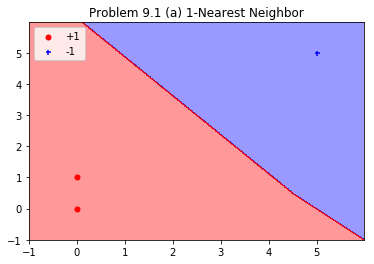

In [4]:
#### Problem 9.1

df = pd.DataFrame({'x1':[0, 0, 5], 'x2':[0, 1, 5], 'y':[1, 1, -1]})
xsp1 = df.loc[df['y']==1]['x1'].values
ysp1 = df.loc[df['y']==1]['x2'].values
xsm1 = df.loc[df['y']==-1]['x1'].values
ysm1 = df.loc[df['y']==-1]['x2'].values

#plt.tight_layout()
X_train = df[['x1', 'x2']].values
y_train = df['y'].values
cls = nn.NearestNeighbors(X_train, y_train, 1)
x1_min, x1_max = -1, 6
x2_min, x2_max = -1, 6
xx1, xx2 = myplot.get_grid(x1_min, x1_max, x2_min, x2_max, step=0.02)
myplot.plot_decision_boundaries(xx1, xx2, 2, cls)

myplot.plt_plot([xsp1, xsm1], [ysp1, ysm1], 'scatter', 
               colors = ['r', 'b'], markers = ['o', '+'], labels = ['+1', '-1'], 
               title = "Problem 9.1 (a) 1-Nearest Neighbor", yscale = None, ylb = -1, yub = 6,
               xlb = -1, xub = 6, xlabel = None, ylabel = None,
               legends = ['+1', '-1'], legendx = None, legendy = None, marker_sizes=[25, 25])

Transformed data points: [[ 0.18441744 -1.40213773]
 [-1.30649561  0.54135868]
 [ 1.12207817  0.86077905]]


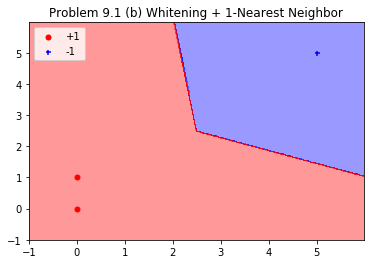

In [5]:
#### Problem 9.1 (b)
Z_train = data.input_whitening(X_train)
print(f"Transformed data points: {Z_train}")
cls = nn.NearestNeighbors(Z_train, y_train, 1, 'classification')
x1_min, x1_max = -1, 6
x2_min, x2_max = -1, 6
xx1, xx2 = myplot.get_grid(x1_min, x1_max, x2_min, x2_max, step=0.02)
myplot.plot_decision_boundaries(xx1, xx2, 2, cls, data.input_whitening)

myplot.plt_plot([xsp1, xsm1], [ysp1, ysm1], 'scatter', 
               colors = ['r', 'b'], markers = ['o', '+'], labels = ['+1', '-1'], 
               title = "Problem 9.1 (b) Whitening + 1-Nearest Neighbor", yscale = None, ylb = -1, yub = 6,
               xlb = -1, xub = 6, xlabel = None, ylabel = None,
               legends = ['+1', '-1'], legendx = None, legendy = None, marker_sizes=[25, 25])

Transformed data points: (3, 1)
[[-2.5797332 ]
 [-1.90465535]
 [ 4.48438855]]


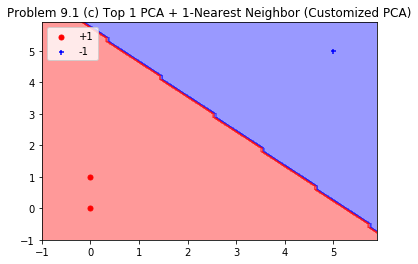

In [6]:
#### Problem 9.1 (c) Use customized PCA

pca_tr = data.PCA(1)
pca_tr.fit(X_train)

def pca_transformer(X):
    Z = pca_tr.transform(X)
    return Z

Z_train = pca_tr.transform(X_train)
print(f"Transformed data points: {Z_train.shape}\n{Z_train}")
cls = nn.NearestNeighbors(Z_train, y_train, 1, 'classification')
x1_min, x1_max = -1, 6
x2_min, x2_max = -1, 6
xx1, xx2 = myplot.get_grid(x1_min, x1_max, x2_min, x2_max, step=0.1)
myplot.plot_decision_boundaries(xx1, xx2, 2, cls, pca_transformer)

myplot.plt_plot([xsp1, xsm1], [ysp1, ysm1], 'scatter', 
               colors = ['r', 'b'], markers = ['o', '+'], labels = ['+1', '-1'], 
               title = "Problem 9.1 (c) Top 1 PCA + 1-Nearest Neighbor (Customized PCA)", yscale = None, ylb = -1, yub = 6,
               xlb = -1, xub = 6, xlabel = None, ylabel = None,
               legends = ['+1', '-1'], legendx = None, legendy = None, marker_sizes=[25, 25])

X_tr: (3, 1)
 [[-2.5797332 ]
 [-1.90465535]
 [ 4.48438855]]


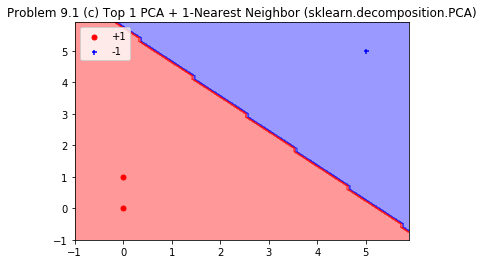

In [7]:
#### Problem 9.1 (c) Use sklearn.decomposition.PCA

mpca = decomposition.PCA(n_components=1)
mpca.fit(X_train)

def pca_t(X):
    Z = mpca.transform(X)
    return Z
    
X_tr = pca_t(X_train)
print(f"X_tr: {X_tr.shape}\n {X_tr}")
cls = nn.NearestNeighbors(X_tr, y_train, 1, 'classification')
myplot.plot_decision_boundaries(xx1, xx2, 2, cls, pca_t)

myplot.plt_plot([xsp1, xsm1], [ysp1, ysm1], 'scatter', 
               colors = ['r', 'b'], markers = ['o', '+'], labels = ['+1', '-1'], 
               title = "Problem 9.1 (c) Top 1 PCA + 1-Nearest Neighbor (sklearn.decomposition.PCA)", yscale = None, ylb = -1, yub = 6,
               xlb = -1, xub = 6, xlabel = None, ylabel = None,
               legends = ['+1', '-1'], legendx = None, legendy = None, marker_sizes=[25, 25])

#### Problem 9.2

* (a) $x'_n = x_n + b$, so $\bar{x}'_n = \bar{x}_n + b$, $z'_n = x'_n - \bar{x}'_n = (x_n+b) - (\bar{x}_n + b) = x_n - \bar{x}_n = z_n$. Centering is robust to this mutation.

$(\sigma'_i)^2 = \frac{1}{N}\sum^N_{n=1} (x'_{ni}-\bar{x}'_{ni})^2 = \frac{1}{N}\sum^N_{n=1} (x_{ni}-\bar{x}_{ni})^2$. Normalization is also robust to this mutation.

$\Sigma' = \frac{1}{N}\sum^N_{n=1}(x'_n - \bar{x}'_n)(x'_n - \bar{x}'_n)^T = \Sigma$. It's clear that this whitening is also robust to the mutation. 

* (b) Uniform scaling: $x'_n = \alpha x_n$, where $\alpha > 0$. 

$\bar{x}'_n = \alpha\bar{x}_n$, $z'_n = \alpha z_n$, centering is not robust to this mutation. 

$(\sigma'_i)^2 = \frac{1}{N}\sum^N_{n=1} (x'_{ni}-\bar{x}'_{ni})^2 = \frac{1}{N}\sum^N_{n=1} \alpha^2(x_{ni}-\bar{x}_{ni})^2 = \alpha^2 (\sigma_i)^2$

so $z'_{ni} = \frac{x'_{ni}}{\sigma'_i} = \frac{\alpha x_{ni}}{\alpha \sigma_i} = z_{ni}$. Normalization is robut to this mutation. 

$\Sigma' = \frac{1}{N}\sum^N_{n=1}(x'_n - \bar{x}'_n)(x'_n - \bar{x}'_n)^T = \alpha^2 \Sigma$.

$z'_n = (\Sigma')^{-\frac{1}{2}} x'_n = \frac{1}{\alpha} \Sigma^{-\frac{1}{2}} \alpha x_n =  z_n$. Whitening is robust to this mutation. 

* (c) $x'_n = Ax_n$

$\bar{x}'_n = A\bar{x}_n$, $z'_n = x'_n -\bar{x}'_n = Az_n$, centering is not robust to this mutation. 

$(\sigma'_i)^2 = \frac{1}{N}\sum^N_{n=1} (x'_{ni}-\bar{x}'_{ni})^2 = \frac{1}{N}\sum^N_{n=1} A^2_{ii}(x_{ni}-\bar{x}_{ni})^2 = A^2_{ii} (\sigma_i)^2$, so $z'_{ni} = \frac{x'_{ni}}{\sigma'_i} = \frac{A_{ii}x_{ni}}{A_{ii} \sigma_i} = z_{ni}$. Normalization is robust to this mutation. 

$\Sigma' = \frac{1}{N}\sum^N_{n=1}(x'_n - \bar{x}'_n)(x'_n - \bar{x}'_n)^T = \frac{1}{N}\sum^N_{n=1} Az_nz^T_n A^T$. Whitening is not robust to this mutation.

* (d) $x'_n = Ax_n$, similar with problem (c), centering is not robust to this mutation. 
Also, $A$ is no longer diagonal, the normalization and whitening are not robust to this mutation neither. 

#### Problem 9.3 

\begin{align*}
\Sigma &= U\Gamma U^T \\
\Sigma &= U \Gamma^{\frac{1}{2}} \Gamma^{\frac{1}{2}} U^T \\
&= U\Gamma^{\frac{1}{2}}U^TU\Gamma^{\frac{1}{2}}U^T\\
&= (U\Gamma^{\frac{1}{2}}U^T)^2\\
&= (\Sigma^{\frac{1}{2}})^2\\
\end{align*}

So $\Sigma^{\frac{1}{2}} = U\Gamma^{\frac{1}{2}}U^T$

\begin{align*}
I &= UU^T \\ 
&= \Gamma^{\frac{1}{2}}U^T U\Gamma^{-\frac{1}{2}}\\
&= U\Gamma^{\frac{1}{2}}U^T U\Gamma^{-\frac{1}{2}}U^T \\
&= \Sigma^{\frac{1}{2}} \Sigma^{-\frac{1}{2}}\\
\end{align*}

So $\Sigma^{-\frac{1}{2}} = U\Gamma^{-\frac{1}{2}}U^T$

$\Gamma^{\frac{1}{2}}$ and $\Gamma^{-\frac{1}{2}}$ are both diagonal matrices, the former with the square root of the eigenvalues of $\Sigma$ and the latter has the $\frac{1}{\sqrt{\lambda_i}}$

#### Problem 9.4

Multiply both sides of $A=V\psi$ by $V^T$, also note that $VV^T = V^TV = I$

\begin{align*}
A &= V\psi \\
\psi &= V^T A \\
\end{align*}

Then we have $\psi^T\psi = A^TV V^T A = I$ and $\psi \psi^T = V^T A A^T V = I$
so $\psi$ is orthogonal matrix. 

#### Problem 9.5

* (a) Let $A' = PA$, where $P$ is the permutation matrix that changes the order of the diagonal entries in $A$ such that the entries in $A'$ are ordered from the largest to the smallest. 

$A=P^{-1}A = U\Gamma V^T$ where $U=P^{-1}, V^T=I, \Gamma = A$, notice $U^TU = (P^{-1})^TU = (P^T)^T P^{-1} = PP^{-1} = I$, since for permutation matrix, we have $P^{-1} = P^T$.

* (b) $A$ is pairwise orthogonal rows. we have $AA^T = I$, also for any $A=U\Gamma V^T$, we have $A = \sum \gamma_i u_i v^T_i$ where $u_i, v_i$ are the column vectors of matrices $U, V$ and $\gamma_i$ are the corresponding singular values. Since $A$ has pairwise orthogonal rows, let $u_i =\begin{bmatrix}0 \\ \dots \\ 1 \\ \dots \\ 0\end{bmatrix}$, the $i$-th base in standard basis. let $A$ be a $m \times n $ matrix, $A = \begin{bmatrix}a_1 \\ \dots \\ a_m\end{bmatrix}$, N.B. $a_i$ are row vectors here. So we have $A = u_1a_1 + \dots + u_ma_m = U\Gamma V^T$, where $U=I, \Gamma = I$ and $V = A^T$.

* (c) $A$ is pairwise orthogonal columns, similarly with problem (b), we have $A = \begin{bmatrix}a_1 & \dots & a_n\end{bmatrix}$, N.B. $a_i$ are column vectors here. So we have $A = a_1u^T_1 + \dots + a_nu^T_n = U\Gamma V^T$, where $U=A, \Gamma = I$ and $V = I$.

* (d) $QA = QU\Gamma V^T = U' \Gamma V^T$, where $U' = QU$ and $(U')^TU' = U^TQ^T Q U = U^T U = I$

* (e) We have $A=U\Gamma V^T = \begin{bmatrix}U_1 & \dots & 0 \\ 0 & U_2 & \dots \\ \dots & \dots & \dots \\ \dots & 0 & U_m \end{bmatrix}\begin{bmatrix}\Gamma_1 & \dots & 0 \\ 0 & \Gamma_2 & \dots \\ \dots & \dots & \dots \\ \dots & 0 & \Gamma_m \end{bmatrix}\begin{bmatrix}V^T_1 & \dots & 0 \\ 0 & V^T_2 & \dots \\ \dots & \dots & \dots \\ \dots & 0 & V^T_m \end{bmatrix}$

#### Problem 9.6

In [9]:
#### Problem 9.6
zip_data_path = './data/usps.h5'


X_train, y_train, X_test, y_test = data.load_zip_data(zip_data_path)

print('X_train: ', X_train.shape, 'y_train: ',y_train.shape, 'X_test: ',X_test.shape, 'y_test: ', y_test.shape)
unique, counts = np.unique(y_train, return_counts=True)
freqs = counts/len(y_train)
print('Frequencies of the digits: \n', dict(zip(unique, freqs)))

y_train, y_test = data.set_two_classes(y_train, y_test, 1)

X_train:  (7291, 256) y_train:  (7291,) X_test:  (2007, 256) y_test:  (2007,)
Frequencies of the digits: 
 {0: 0.16376354409546015, 1: 0.13784117405019888, 2: 0.10026059525442327, 3: 0.09024825126868742, 4: 0.08942531888629818, 5: 0.07625840076807022, 6: 0.09107118365107666, 7: 0.08846523110684405, 8: 0.07433822520916199, 9: 0.08832807570977919}


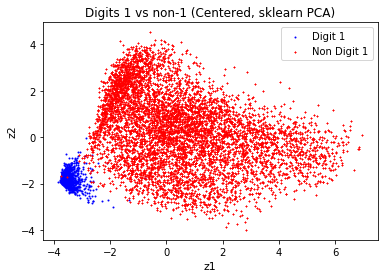

In [12]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
X_tr = pca.transform(X_train)
x1s = [X_tr[y_train==1, 0], X_tr[y_train==-1, 0]]
x2s = [X_tr[y_train==1, 1], X_tr[y_train==-1, 1]]
myplot.plt_plot(x1s, x2s, 'scatter', ['b', 'r'], ['o', 'x'], ['Digit 1', 'Non Digit 1'], 
        title = 'Digits 1 vs non-1 (Centered, sklearn PCA)', yscale = None, ylb = None, yub = None,
        xlb = None, xub = None, xlabel = 'z1', ylabel = 'z2',
        legends = ['+', '-'], legendx = None, legendy = None) 

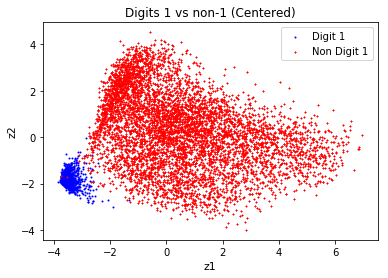

In [10]:
mypca = data.PCA(2)
mypca.fit(X_train)
X_tr = mypca.transform(X_train)

x1s = [X_tr[y_train==1, 0], X_tr[y_train==-1, 0]]
x2s = [X_tr[y_train==1, 1], X_tr[y_train==-1, 1]]
myplot.plt_plot(x1s, x2s, 'scatter', ['b', 'r'], ['o', 'x'], ['Digit 1', 'Non Digit 1'], 
        title = 'Digits 1 vs non-1 (Centered)', yscale = None, ylb = None, yub = None,
        xlb = None, xub = None, xlabel = 'z1', ylabel = 'z2',
        legends = ['+', '-'], legendx = None, legendy = None) 

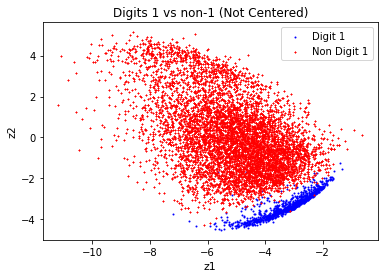

In [11]:
mypca = data.PCA(2,centering=False)
mypca.fit(X_train)
X_tr = mypca.transform(X_train)

x1s = [X_tr[y_train==1, 0], X_tr[y_train==-1, 0]]
x2s = [X_tr[y_train==1, 1], X_tr[y_train==-1, 1]]
myplot.plt_plot(x1s, x2s, 'scatter', ['b', 'r'], ['o', 'x'], ['Digit 1', 'Non Digit 1'], 
        title = 'Digits 1 vs non-1 (Not Centered)', yscale = None, ylb = None, yub = None,
        xlb = None, xub = None, xlabel = 'z1', ylabel = 'z2',
        legends = ['+', '-'], legendx = None, legendy = None) 

The transformed data don't seem to be whitened.

#### Problem 9.7

Let $X=\begin{bmatrix} x^T_1 \\ \dots \\ x^T_N \end{bmatrix}$ be the $N\times d$ data matrix. From SVD we have $X=U\Gamma V^T$, where $U$ is $N \times d$, $\Gamma, V$ are $d \times d $ matrices.

Let $V_k$ be the first $k$ columns from $V$, so it has dimension of $d\times k$. Let $U_k$ be the first $k$ columns from $U$, it has dimension of $N\times k$ and $U^T_k U_k = I_k$. Also $\Gamma_k$ is the $k\times k$ diagonal matrix with the first $k$ singular values on the diagonal. 

From SVD we have $X=U\Gamma V^T$, so $XV=U\Gamma$ and $X\begin{bmatrix}V_k & V_r \end{bmatrix} = \begin{bmatrix}U_k & U_r \end{bmatrix} \begin{bmatrix}\Gamma'_k \\ \Gamma'_r \end{bmatrix}$. 

Where $V_r$ has a dimension of $d\times (d-k)$ and $U_r$ has dimension of $N\times (d-k)$, $\Gamma'_k$ is the first $k$ rows in $\Gamma$ and has a dimension of $k\times d$ and $\Gamma'_r$ has a dimension of $(d-k)\times d$. We thus have

$XV_k = U_k\Gamma_k$

So we have $Z=\begin{bmatrix} z^T_1 \\ \dots \\ z^T_N \end{bmatrix} = \begin{bmatrix} (\Gamma^{-1}_kV^T_kx_1)^T \\ \dots \\ (\Gamma^{-1}_kV^T_kx_N)^T \end{bmatrix} = \begin{bmatrix} x^T_1V_k\Gamma^{-1}_k \\ \dots \\ x^T_NV_k\Gamma^{-1}_k \end{bmatrix} = XV_k\Gamma^{-1}_k$, so $Z$ has a dimension of $N\times k$

so $Z^TZ = \Gamma^{-1}_kV^T_kX^T XV_k\Gamma^{-1}_k = \Gamma^{-1}_k (U_k\Gamma_k)^TU_k\Gamma_k\Gamma^{-1}_k = \Gamma^{-1}_k \Gamma_kU^T_kU_k\Gamma_k\Gamma^{-1}_k = I$

#### Problem 9.8 TODO

In [1]:
# Add lib input sys.path
import os
import sys
import time

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.preprocessing import normalize
from functools import partial
import h5py
from scipy.spatial import distance

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from matplotlib.colors import ListedColormap
import libs.linear_models as lm
import libs.data_util as data
import libs.nn as nn
import libs.plot as myplot
from sklearn import decomposition

%matplotlib inline

#### Problem 9.9

* (a) If $\hat{X}$ is a reconstruction of $X$ whose rows are the data points in $X$ projected onto $k$ basis vectors, then suppose the $k$ basis vectors are in $B$ with dimension of $d\times k$, then we have $\hat{X} = XBB^T$, with dimension of $N\times d$. There are at most $k$ independent columns in $\hat{X}$, so $\text{rank}(\hat{X}) \le k$


* (b) Since $U_{N\times d},V_{d\times d}, V^T$ have orthonormal columns, i.e. $U^TU=I, (V^T)^TV^T = VV^T=I$,  we have 

Let $Z=(X-\hat{X})^TU = YU$, it's also $z=U^Ty$, where $z$ are the columns in $Z$ and $y^T$ are the rows in $Y$.  Since $U$ has orthonormal columns, we can treat $Z$ as a transformed data matrix of $Y = (X-\hat{X})^T$. Note $Y$ has a dimension of $d\times N$, so the rows in $Y$, i.e. $y$,  are in a space of $R^N$.  While the basis vectors in $U$ is also in space $R^N$, but we only select $d$ basis vectors in this space (since $U$ has a dimension of $N\times d$). From exercise 9.7 (c), we have $\|z\| \le \|y\| $, we see that $\|Z\|^2 = \sum \|z\|^2 \le \sum \|y\|^2 = \|Y\|^2 = \|(X-\hat{X})^T\|^2 = \|X-\hat{X}\|^2$. That is

$\|X-\hat{X}\|^2 \ge \|(X-\hat{X})^TU\|^2_F  = \|U^T(X-\hat{X})\|^2_F = \|U^T(X-\hat{X})V\|^2_F = \|U^TXV-U^T\hat{X}V\|^2_F = \|\Gamma-U^T\hat{X}V\|^2_F$

Where we have applied the results of Exercise 9.9 on $V$ on the second equation above.

* (c) Let $\hat{\Gamma} = U^T\hat{X}V$, we have $\text{rank}(\hat{\Gamma}) = \text{rank}(U^T\hat{X}V) \le \text{rank}(\hat{X}V) \le \text{rank}(\hat{X}) \le k $ from problem (a)

* (d) We want to minimize the difference $\|\Gamma-U^T\hat{X}V\|^2_F$, since the Frobenius norm is defined as the sum of squares of each element in the matrix, we want to have the difference between $\Gamma$ and $\hat{\Gamma}$ to be zero. Since $\Gamma$ has zeros on all off-diagonal elements, it's optimal to choose zeros on the off-diagonal elements in $\hat{\Gamma}$ as well, so their differences on off-diagonal are all zero.

* (e) Since $\hat{\Gamma}$ has a rank of at most $k$, the non-zero diagonals can be at most $k$.

* (f) If we select the first $k$ singular values from $\Gamma$ as the first $k$ elements in $\hat{\Gamma}$, we have the optimal choice here. Otherwise, if there's any singular value after $k$ in $\hat{\Gamma}$, we can always swap it with the missing singular value from first $k$ items, and obtain a smaller error. 

* (g) $\hat{X} = XVV^T =  X$, so we have $\hat{\Gamma} = U^T\hat{X}V=U^TXV=\Gamma$, we have exact match with $\Gamma$



#### Problem 9.10 TODO
#### Problem 9.11 TODO

#### Problem 9.12

* (a) 

\begin{align*}
E^{\pi}_{out}(h) &= \frac{1}{4}E_{x,\pi}\left[(h(x)-f_{\pi}(x))^2\right] \\
&= \frac{1}{4}E_{x}E_{\pi|x}\left[(h(x)-f_{\pi}(x))^2\right] \\
&= \frac{1}{4}\sum^N_{n=1}P(x=x_n)E_{\pi|x=x_n}\left[(h(x_n)-f_{\pi}(x_n))^2\right] \\
&= \frac{1}{4N}\sum^N_{n=1}E_{\pi|x=x_n}\left[(h(x_n)-f_{\pi}(x_n))^2\right] \\
&= \frac{1}{4N}\sum^N_{n=1}E_{\pi}\left[(h(x_n)-f_{\pi}(x_n))^2\right] \\
\end{align*}

* (b) 

Let $\bar{y} = \frac{1}{N}\sum_n y_n$ and $s^2_y = \frac{1}{N}\sum_n(y_n - \bar{y})^2$

\begin{align*}
E^{\pi}_{out}(h) &=\frac{1}{4N}\sum^N_{n=1}E_{\pi}\left[(h(x_n)-f_{\pi}(x_n))^2\right] \\
&= \frac{1}{4N}\sum^N_{n=1}E_{\pi}\left[(h(x_n)-\bar{y} + \bar{y} - f_{\pi}(x_n))^2\right] \\
&= \frac{1}{4N}\sum^N_{n=1}E_{\pi}\left[(h(x_n)-\bar{y})^2 + 2(h(x_n)-\bar{y})(f_{\pi}(x_n)-\bar{y}) + (f_{\pi}(x_n)-\bar{y})^2\right] \\
&= \frac{1}{4N}\sum^N_{n=1}E_{\pi}[(h(x_n)-\bar{y})^2] + 2E_{\pi}[(h(x_n)-\bar{y})(f_{\pi}(x_n)-\bar{y})] + E_{\pi}[(f_{\pi}(x_n)-\bar{y})^2] \\
&= \frac{1}{4N}\sum^N_{n=1}\left[(h(x_n)-\bar{y})^2 + 2E_{\pi}[(h(x_n)-\bar{y})(f_{\pi}(x_n)-\bar{y})] + E_{\pi}[(f_{\pi}(x_n)-\bar{y})^2]\right] \\
&= \frac{1}{4N}\sum^N_{n=1}\left[(h(x_n)-\bar{y})^2 + 2(h(x_n)-\bar{y})E_{\pi}[(f_{\pi}(x_n)-\bar{y})] + s^2_y\right] \\
&= \frac{1}{4N}\sum^N_{n=1}\left[(h(x_n)-\bar{y})^2 + s^2_y\right] \\
&= \frac{1}{4N}\sum^N_{n=1}(h(x_n)-\bar{y})^2 + \frac{1}{4}s^2_y \\
\end{align*}

* (c) $E^{\pi}_{in}(g_{\pi}) = \frac{1}{4N}\sum^N_{n=1} (g_{\pi}(x_n) - y_{\pi_n})^2$

* (d) The permutation optimism penalty is thus

\begin{align*}
E^{\pi}_{out}(g_{\pi}) - E^{\pi}_{in}(g_{\pi}) &= \frac{1}{4N}\sum^N_{n=1}(g_{\pi}(x_n)-\bar{y})^2 + \frac{1}{4}s^2_y - \frac{1}{4N}\sum^N_{n=1} (g_{\pi}(x_n) - y_{\pi_n})^2\\
 &= \frac{1}{4N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})(2g_{\pi}(x_n) - y_{\pi_n}-\bar{y} ) + \frac{1}{4}s^2_y\\
 &= \frac{1}{2N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})g_{\pi}(x_n) + \frac{1}{4N}\sum^N_{n=1}(\bar{y}^2 - y^2_{\pi_n}) + \frac{1}{4}\frac{1}{N}\sum^N_{n=1}(y_{\pi_n} - \bar{y})^2\\
 &= \frac{1}{2N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})g_{\pi}(x_n) + \frac{1}{4N}\sum^N_{n=1}2\bar{y}(\bar{y} - y_n)\\
 &= \frac{1}{2N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})g_{\pi}(x_n)\\
\end{align*}

* (e) The correlation between $y_{\pi_n}$ and $g_{\pi}(x_n)$ is 

\begin{align*}
\frac{1}{4N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})(g_{\pi}(x_n) - \bar{g_{\pi}}) &= \frac{1}{4N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})g_{\pi}(x_n) - \frac{1}{4N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})\bar{g_{\pi}}\\
&= \frac{1}{4N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})g_{\pi}(x_n) - \bar{g_{\pi}}\frac{1}{4N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})\\
&= \frac{1}{4N}\sum^N_{n=1}(y_{\pi_n}-\bar{y})g_{\pi}(x_n)\\
\end{align*}

So it is proportional to the permutation optimism.

#### Problem 9.13

The target distribution for the random problem using sampling of the targets with replacement, then we have  $P[f_{\pi}(x_n)=y_m] = \frac{1}{N}$.

Follow the steps in problem 9.12, we shall obtain equation (9.5) as well.

#### Problem 9.14 TODO

#### Problem 9.15

For a single hypothesis we have $P[|E_{out}(h) - E_{in}(h)| > \epsilon] \le 2e^{-2N\epsilon^2}$. The Rademacher variables $r_n$ are $+1,-1$, so the growth function $m_{\mathcal{H}}(N)$ is the exact number of hypotheses in $\mathcal{H}$ for $N$ data points.  We are selecting $g_r$ from  $m_{\mathcal{H}}(N)$ hypotheses, so we have 

$P[|E'_{out}(g_r) - E'_{in}(g_r)| > \epsilon] \le 2m_{\mathcal{H}}(N)e^{-2N\epsilon^2}$

Let $\delta = 2m_{\mathcal{H}}(N)e^{-2N\epsilon^2}$, i.e. $\epsilon = \sqrt{\frac{1}{2N}\ln\frac{2m_{\mathcal{H}}}{\delta}}$. Thus with probability at least $1-\delta$, we have

$E'_{out}(g_r) - E'_{in}(g_r) \le \epsilon = \sqrt{\frac{1}{2N}\ln\frac{2m_{\mathcal{H}(N)}}{\delta}}$

#### Problem 9.16 TODO
#### Problem 9.17 TODO

#### Problem 9.18

* (a) From $\hat{y}^{(\pi)} = Hy^{(\pi)}$, we have $\hat{y}^{(\pi)}_n = \sum_m H_{nm}y^{(\pi)}_m = \sum_m H_{nm}y_{\pi_m}$. The permutation optimism penalty is thus

\begin{align*}
\frac{2}{N}\sum^N_{n=1}(y_{\pi_n} - \bar{y})g_{(\pi)}(x_n) &= \frac{2}{N}\sum^N_{n=1}(y_{\pi_n} - \bar{y})\sum_m H_{nm}y_{\pi_m} \\ 
&= \frac{2}{N}\sum^N_{n=1}\sum_m(y_{\pi_n} - \bar{y}) H_{nm}y_{\pi_m} \\
&=\frac{2}{N}\sum^N_{n=1}\sum_m H_{nm}(y_{\pi_n}y_{\pi_m}  - \bar{y}y_{\pi_m} )\\
&=\frac{2}{N}\sum_{m,n=1}H_{mn}(y_{\pi_m}y_{\pi_n}  - \bar{y}y_{\pi_n} )\\
\end{align*}

* (b) 

\begin{align*}
E_{\pi}[y_{\pi_n}] &= \sum^N_{k=1}y_k P[y_{\pi_n} = y_k] \\
&= \sum^N_{k=1}y_k \frac{1}{N} \\
&= \bar{y}\\
\end{align*}

When $m=n$, we have

\begin{align*}
E_{\pi}[y_{\pi_m}y_{\pi_n}] &= \sum^N_{n=1}y^2_n P[y_{\pi_m} = y_n]  \\
&= \sum^N_{n=1}\frac{1}{N}y^2_n   \\
&= \bar{y}^2 + s^2_y \\
\end{align*}

When $m\ne n$, we have

\begin{align*}
E_{\pi}[y_{\pi_m}y_{\pi_n}] &= \sum^N_{m=1}\sum^N_{n\ne m}y_my_n P[y_{\pi_m} = y_m, y_{\pi_n}=y_n]  \\
&= \sum^N_{m=1}\sum^N_{n\ne m}y_my_n P[y_{\pi_m} = y_m]P[y_{\pi_n}=y_n]  \\
&= \sum^N_{m=1}\sum^N_{n\ne m}y_my_n \frac{1}{N}\frac{1}{N-1}\\
&= \frac{1}{N(N-1)}\sum^N_{m=1}y_m \sum^N_{n\ne m}y_n \\
&= \frac{1}{N(N-1)}\sum^N_{m=1}y_m (N\bar{y} - y_m) \\
&= \frac{1}{(N-1)}\bar{y}\sum^N_{m=1}y_m  - \frac{1}{N(N-1)}\sum^N_{m=1}y^2_m \\
&= \frac{N}{(N-1)}\bar{y}^2  - \frac{1}{N(N-1)}(N(\bar{y}^2 + s^2_y)) \\
&= \bar{y}^2  - \frac{s^2_y}{N-1} \\
\end{align*}

* (c) Take the expectation of the penalty in (a), we have

\begin{align*}
E\left[\frac{2}{N}\sum_{m,n=1}H_{mn}(y_{\pi_m}y_{\pi_n}  - \bar{y}y_{\pi_n} )\right] &= \frac{2}{N}\sum_{m,n=1}H_{mn}E[y_{\pi_m}y_{\pi_n}  - \bar{y}y_{\pi_n}]\\
 &= \frac{2}{N}\sum_{m,n=1}H_{mn}\left(E[y_{\pi_m}y_{\pi_n}]  - \bar{y}E[y_{\pi_n}]\right)\\
 &= \frac{2}{N}\sum_{m,n=1}H_{mn}\left(E[y_{\pi_m}y_{\pi_n}]  - \bar{y}^2\right)\\
 &= \left(\frac{2}{N}\sum_{m=n}H_{mn}(E[y_{\pi_m}y_{\pi_n}]  - \bar{y}^2)\right)  + \left(\frac{2}{N}\sum_{m\ne n}H_{mn}(E[y_{\pi_m}y_{\pi_n}]  - \bar{y}^2)\right)\\
 &= \left(\frac{2}{N}\sum^N_{n=1}H_{nn}s^2_y\right) - \left(\frac{2}{N}\sum_{m\ne n}H_{mn} \frac{1}{N-1}s^2_y\right)\\
 &= \frac{2}{N}\left(s^2_y\text{trace}(H) - \sum_{m\ne n}H_{mn} \frac{1}{N-1}s^2_y\right)\\
 &= \frac{2s^2_y}{N}\left(\text{trace}(H) -\frac{1}{N-1} \sum_{m\ne n}H_{mn}\right)\\
 &= \frac{2s^2_y}{N}\left(\text{trace}(H) -\frac{1}{N-1} (1^TH1 - \text{trace}(H))\right)\\
 &= \frac{2s^2_y}{N-1}\left(\frac{N-1}{N}\text{trace}(H) -\frac{1}{N} (1^TH1 - \text{trace}(H))\right)\\
 &= \frac{2s^2_y}{N-1}\left(\text{trace}(H) -\frac{1^TH1 }{N}\right)\\
 &= \frac{2\hat{\sigma}^2_y}{N}\left(\text{trace}(H) -\frac{1^TH1 }{N}\right)\\
\end{align*}




#### Problem 9.19
Follow the same derivation as in problem 9.18, we have 

When $m=n$, we have

\begin{align*}
E_{\pi}[y_{\pi_m}y_{\pi_n}] &= \bar{y}^2 + s^2_y \\
\end{align*}

When $m\ne n$, note we can still have $y_{\pi_m} = y_{\pi_n}$ even when $m\ne n$, so we have

\begin{align*}
E_{\pi}[y_{\pi_m}y_{\pi_n}] &= \sum^N_{i=1}\sum^N_{j=1}y_iy_j P[y_{\pi_m} = y_i, y_{\pi_n}=y_j]  \\
&= \sum^N_{i=1}\sum^N_{j=1}y_iy_j P[y_{\pi_m} = y_i]P[y_{\pi_n}=y_j]  \\
&= \sum^N_{i=1}\sum^N_{j=1}y_iy_j \frac{1}{N}\frac{1}{N}\\
&= \frac{1}{N^2}\sum^N_{i=1}y_i \sum^N_{j=1}y_j \\
&= \bar{y}^2\\
\end{align*}

Take the expectation of the penalty in (a), we have

\begin{align*}
E\left[\frac{2}{N}\sum_{m,n=1}H_{mn}(y_{\pi_m}y_{\pi_n}  - \bar{y}y_{\pi_n} )\right] &= \frac{2}{N}\sum_{m,n=1}H_{mn}E[y_{\pi_m}y_{\pi_n}  - \bar{y}y_{\pi_n}]\\
 &= \frac{2}{N}\sum_{m,n=1}H_{mn}\left(E[y_{\pi_m}y_{\pi_n}]  - \bar{y}E[y_{\pi_n}]\right)\\
 &= \frac{2}{N}\sum_{m,n=1}H_{mn}\left(E[y_{\pi_m}y_{\pi_n}]  - \bar{y}^2\right)\\
 &= \left(\frac{2}{N}\sum_{m=n}H_{mn}(E[y_{\pi_m}y_{\pi_n}]  - \bar{y}^2)\right)  + \left(\frac{2}{N}\sum_{m\ne n}H_{mn}(E[y_{\pi_m}y_{\pi_n}]  - \bar{y}^2)\right)\\
 &= \frac{2}{N}\sum^N_{n=1}H_{nn}s^2_y\\
 &= \frac{2s^2_y}{N}\text{trace}(H)\\
 \end{align*}
 
 #### Problem 9.20
 
 See the answer in [Problem 5.2](https://github.com/niuers/Learn-From-Data-A-Short-Course/blob/master/Solutions%20to%20Chapter%205%20Exercises%20and%20Problems.ipynb)

#### Problem 9.21

* (a) From [Problem 4.26](https://github.com/niuers/Learn-From-Data-A-Short-Course/blob/master/Solutions%20to%20Chapter%204%20Exercises%20and%20Problems.ipynb), we have the error on $x_n$ from data set $\mathcal{D}_m$ as $e_n = \left(\frac{\hat{y}^{(m)}_n - y_n}{1-H^{(m)}_{nn}}\right)^2$, so the cross validation error for this data set is 

$E_{CV}(\mathcal{D}_m) = \frac{1}{N-1}\sum_{n\ne m} \left(\frac{\hat{y}^{(m)}_n - y_n}{1-H^{(m)}_{nn}}\right)^2$ 

as there are only $N-1$ data points.

* (b) Let $H, A$ correspond to the full data set $\mathcal{D}$

From problem 4.26, we have $H^{(m)}_{nk} = z^T_n(A^{(m)})^{-1}z_k$ and $A^{(m)} = A - z_mz^T_m$, so 

\begin{align*}
H^{(m)}_{nk} &= z^T_n(A^{(m)})^{-1}z_k \\
&= z^T_n\left(A - z_mz^T_m\right)^{-1}z_k\\
&\text{apply problem 4.26(b)}\\
&= z^T_n\left(A^{-1} + \frac{A^{-1}z_mz^T_mA^{-1}}{1-z^T_mA^{-1}z_m}\right)z_k\\
&= z^T_nA^{-1}z_k + \frac{z^T_nA^{-1}z_mz^T_mA^{-1}z_k}{1-z^T_mA^{-1}z_m}\\
&= H_{nk} + \frac{H_{mn}H_{mk}}{1-H_{mm}}\\
\end{align*}

* (c) We have $\hat{y} = Hy$, so 

\begin{align*}
\hat{y}^{(m)}_n &= \sum^{N}_{k=1, k\ne m} H^{(m)}_{nk}y_k \\
&= \sum^N_{k=1,k\ne m} \left(H_{nk} + \frac{H_{mn}H_{mk}}{1-H_{mm}}\right)y_k\\
&= \sum^N_{k=1,k\ne m} \left(H_{nk}y_k + \frac{H_{mn}H_{mk}}{1-H_{mm}}y_k\right)\\
&= \sum^N_{k=1} \left(H_{nk}y_k + \frac{H_{mn}H_{mk}}{1-H_{mm}}y_k\right) - (H_{nm} + \frac{H_{mn}H_{mm}}{1-H_{mm}})y_m\\
&= \hat{y}_n + \sum_k \frac{H_{mn}H_{mk}}{1-H_{mm}}y_k - \frac{H_{mn}}{1-H_{mm}}y_m\\
&= \hat{y}_n + \frac{H_{mn}}{1-H_{mm}} \sum_k H_{mk}y_k- \frac{H_{mn}}{1-H_{mm}}y_m \\
&= \hat{y}_n + \frac{H_{mn}}{1-H_{mm}} \hat{y}_m - \frac{H_{mn}}{1-H_{mm}}y_m\\
&= \hat{y}_n + \frac{\hat{y}_m - y_m}{1-H_{mm}}H_{mn} \\
\end{align*}

* (d) Take the results of problem (b), (c) into the formula for $E_{CV}(\mathcal{D}_m)$ we have

\begin{align*}
E_{CV}(\mathcal{D}_m) &= \frac{1}{N-1}\sum_{n\ne m} \left(\frac{\hat{y}^{(m)}_n - y_n}{1-H^{(m)}_{nn}}\right)^2 \\
&= \frac{1}{N-1}\sum_{n\ne m} \left(\frac{\hat{y}_n + \frac{\hat{y}_m - y_m}{1-H_{mm}}H_{mn}  - y_n}{1-(H_{nn} + \frac{H_{mn}H_{mn}}{1-H_{mm}})}\right)^2\\
&= \frac{1}{N-1}\sum_{n\ne m} \left(\frac{\hat{y}_n - y_n + \frac{\hat{y}_m - y_m}{1-H_{mm}}H_{mn}  }{1-H_{nn} - \frac{H^2_{mn}}{1-H_{mm}}}\right)^2 \\
&= \frac{1}{N-1}\sum_{n=1} \left(\frac{\hat{y}_n - y_n + \frac{\hat{y}_m - y_m}{1-H_{mm}}H_{mn}  }{1-H_{nn} - \frac{H^2_{mn}}{1-H_{mm}}}\right)^2  - \frac{1}{N-1}\left(\frac{\hat{y}_m - y_m}{1-2H_{mm}}\right)^2\\
\end{align*}

* (e) We also have $E_{CV}(\mathcal{D}) = \frac{1}{N}\sum_{n=1} \left(\frac{\hat{y}_n - y_n}{1-H_{nn}}\right)^2$

so the leverage $l_m = E_{CV}(\mathcal{D}) - E_{CV}(\mathcal{D}_m)$

To compute the leverage, we only need calculate the hat matrix $H$ for the full data set $\mathcal{D}$ once, and make predictions $\hat{y}$ once. 
So this is $N$ times more cost than a normal linear regression.

#### Problem 9.22 TODO
#### Problem 9.23 TODO

#### Problem 9.24

* (a) For $\hat{t}_n$, we use $N-1$ data points to estimate $t$, since $\hat{t}(\mathcal{Z}_n)$ is asymptotically unbiased, we have

$E_{\mathcal{Z}}[\hat{t}(\mathcal{Z})] = t + \frac{a_1}{N-1} + \frac{a_2}{(N-1)^2} + \dots $

* (b) 

\begin{align*}
E_{\mathcal{Z}}[\hat{\tau}_n] &= E_{\mathcal{Z}}[N\hat{t}(\mathcal{Z}) - (N-1)\hat{t}_n]\\
&= NE_{\mathcal{Z}}[\hat{t}(\mathcal{Z})] - (N-1)E_{\mathcal{Z}}[\hat{t}_n]\\
&= N(t+\frac{a_1}{N} + \frac{a_2}{N^2} + \dots) - (N-1)(t + \frac{a_1}{N-1} + \frac{a_2}{(N-1)^2} + \dots)\\
&= t - \frac{a_2}{N(N-1)} + O(\frac{1}{N^2})\\
\end{align*}

* (c) It's clear that with $N-1$ data points, we have 

\begin{align*}
s^2_n &= \frac{1}{N-1}\left(\sum^N_{m=1}x^2_m - x^2_n\right) - \frac{1}{(N-1)^2}\left(\sum^N_{m=1}x_m - x_n\right)^2\\
&= \frac{1}{N-1}\sum^N_{m=1}x^2_m - \frac{1}{N-1}x^2_n- \frac{1}{(N-1)^2}\left(\left(\sum^N_{m=1}x_m\right)^2 -2 x_n\sum^N_{m=1}x_m + x^2_n\right)\\
&= \frac{1}{N-1}\sum^N_{m=1}x^2_m - \frac{1}{(N-1)^2}\left(\sum^N_{m=1}x_m\right)^2 - \frac{N}{(N-1)^2}x^2_n + \frac{2x_n}{(N-1)^2} \sum^N_{m=1}x_m\\
\end{align*}


\begin{align*}
s^2_J &= Ns^2 - \frac{N-1}{N}\sum_n s^2_n \\
&= \sum^N_{n=1}x^2_n - \frac{1}{N}\left(\sum^N_{n=1}x_n\right)^2 - \sum_n \left[\frac{1}{N}\sum^N_{m=1}x^2_m - \frac{1}{N(N-1)}\left(\sum^N_{n=1}x_n\right)^2 - \frac{1}{N-1}x^2_n + \frac{2x_n}{N(N-1)} \sum^N_{n=1}x_n  \right] \\
&= \frac{1}{N(N-1)}\left(\sum^N_{n=1}x_n\right)^2 - \frac{2}{N(N-1)}\sum^N_{n=1}x_n \sum^N_{m=1}x_m + \frac{1}{N-1}\sum^N_{n=1}x^2_n  \\
&= \frac{1}{N-1}\sum^N_{n=1}x^2_n - \frac{1}{N(N-1)}\left(\sum^N_{n=1}x_n\right)^2 \\
&= \frac{N}{N-1}\left(\frac{1}{N}\sum^N_{n=1}x^2_n - \frac{1}{N^2}\left(\sum^N_{n=1}x_n\right)^2\right) \\
&= \frac{N}{N-1}s^2\\
\end{align*}

* (d) If $t(\mathcal{Z})$ has an asymptotic bias, the $E_{\mathcal{Z}}[\hat{\tau}_n]$ will have the same bias. The jackknife estimate will have the same bias as well.

* (e) If the leading order term in the bias was $\frac{1}{N^2}$, since $\frac{1}{N}$ term doesn't appear in $E_{\mathcal{Z}}[\hat{\tau}_n]$, so it's not affected by the $\frac{1}{N}$ term, the Jackknife estimate will have the same bias.

#### Problem 9.25

* (a) The $E_{in}$ is downward biased, i.e. tend to lower the estimate of $\mathcal{E}_{out}(N)$. When the number of points $N$ is large, it is asymptotically unbiased.

* (b) The $E_{in}(g^{(\mathcal{D})})$ is the estimate with full data set, and $E_{in}(g^{(\mathcal{D}_n)})$ is the estimate with leave one out sample set.
  * (i) The pseudo-values are $\hat{\tau}_n = NE_{in}(g^{(\mathcal{D})}) - (N-1)E_{in}(g^{(\mathcal{D}_n)})$ by definition.
  * (ii) The jackknife estimate is thus $E_J = NE_{in}(g^{(\mathcal{D})}) - \frac{N-1}{N}\sum^N_{n=1}E_{in}(g^{(\mathcal{D}_n)})$
  
* (c) Take expectation on   $E_{in}(g^{(\mathcal{D}_n)})$, since it has $N-1$ data points, we have

$E_{\mathcal{D}}[E_{in}(g^{(\mathcal{D}_n)})] = \mathcal{E}_{out}(N-1) + \frac{a_1}{N-1} + \frac{a_2}{(N-1)^2} + \dots$

Take expectation on $E_J$ we have

\begin{align*}
E_{\mathcal{D}}[E_J] &= N E_{\mathcal{D}}\left[ E_{in}(g^{(\mathcal{D})})\right] - \frac{N-1}{N}\sum^N_{n=1} E_{\mathcal{D}}\left[E_{in} (g^{(\mathcal{D}_n)}) \right]\\
&= N\left[\mathcal{E}(N)+\frac{a_1}{N}+\frac{a_2}{N^2}\right] - \frac{N-1}{N}\sum^N_{n=1}\left[\mathcal{E}(N-1)+\frac{a_1}{N-1}+\frac{a_2}{(N-1)^2}\right]\\
&= \mathcal{E}(N) + (N-1)(\mathcal{E}(N) - \mathcal{E}(N-1)) + O(\frac{1}{N^2})\\
\end{align*}

* (d) If the learning curve converges, then we have

\begin{align*}
E_{\mathcal{D}}[E_J] &= \mathcal{E}(N) + (N-1)(\mathcal{E}(N) - \mathcal{E}(N-1)) + O(\frac{1}{N^2}) \\
&= \mathcal{E}(N)  + (N-1)\left(E + \frac{b_1}{N}+\frac{b_2}{N^2} - (E + \frac{b_1}{N-1}+\frac{b_2}{(N-1)^2})\right) + O(\frac{1}{N^2})\\
&= \mathcal{E}(N)  - \frac{b_1}{N} +  O(\frac{1}{N^2})\\
\end{align*}

When the learning curve bias term is smaller than the in-sample bias term, for example, when the sample is not representative of the data distribution. Jackknife estimate will be helpful.

#### Problem 9.26 TODO
#### Problem 9.27 TODO
#### Problem 9.28 TODO